# Makeover Monday Week 12

In [48]:
import os
import pandas as pd
import datetime as datetime

import matplotlib
import matplotlib.pylab as pl

import numpy as np
import seaborn.apionly as sns
%matplotlib inline

Let's start by loading the data.

## Data

Data source: https://data.world/sports/ncaa-mens-march-madness

In [52]:
data_folder = os.environ['HOME'] + '/Downloads/'

In [53]:
file = 'NCAA Mens March Madness Historical Results.csv'

In [54]:
data = pd.read_csv(data_folder + file)

## Functions

In [5]:
# get rid of commas, spaces, upper case characters:
def clean_name(name):
    return name.replace(' ', '-').lower()

In [6]:
data.columns = [x.lower() for x in data.columns]
data.columns = [x.replace(' ', '_') for x in data.columns]

In [7]:
# data.loser = data.loser.apply(lambda x: clean_name(x))
# data.winner = data.winner.apply(lambda x: clean_name(x))

In [8]:
data.head(2)

,date,round,region,winning_seed,winner,winning_score,losing_seed,loser,losing_score,overtime
0,3/14/85,Round of 64,East,1,Georgetown,68,16,Lehigh,43,NaN
1,3/14/85,Round of 64,East,4,"Loyola, Illinois",59,13,Iona,58,NaN


In [9]:
data.head(1)

,date,round,region,winning_seed,winner,winning_score,losing_seed,loser,losing_score,overtime
0,3/14/85,Round of 64,East,1,Georgetown,68,16,Lehigh,43,NaN


In [10]:
data['round'].unique()

array(['Round of 64', 'Round of 32', 'Sweet Sixteen', 'Elite Eight',
       'National Semifinals', 'National Championship', 'Opening Round'], dtype=object)

Let's create a dictionary here so that we can introduce some order:

In [11]:
round_dict = {
    'Opening Round': 1,
    'Round of 64': 2, 
    'Round of 32': 3,
    'Sweet Sixteen': 4, 
    'Elite Eight': 5,
    'National Semifinals': 6, 
    'National Championship': 7}

In [12]:
data['round_num'] = [round_dict[x] for x in data['round'].values]

Rename the "round" column as it interferes with Python's built-in 'round' function.

In [13]:
data.rename(columns={'round': 'which_round'}, inplace=True)

In [14]:
data.head(2)

,date,which_round,region,winning_seed,winner,winning_score,losing_seed,loser,losing_score,overtime,round_num
0,3/14/85,Round of 64,East,1,Georgetown,68,16,Lehigh,43,NaN,2
1,3/14/85,Round of 64,East,4,"Loyola, Illinois",59,13,Iona,58,NaN,2


Let's make sure we've got the correct number of entries per round.

In [15]:
data.date = pd.to_datetime(data.date)

Let's add a column for year so that we can group events by year.

In [16]:
data['year'] = data.date.apply(lambda x: x.year)

In [17]:
data.groupby(['year', 'which_round']).count()['round_num'].head(12)

year  which_round          
1985  Elite Eight               4
      National Championship     1
      National Semifinals       2
      Round of 32              16
      Round of 64              32
      Sweet Sixteen             8
1986  Elite Eight               4
      National Championship     1
      National Semifinals       2
      Round of 32              16
      Round of 64              32
      Sweet Sixteen             8
Name: round_num, dtype: int64

Looks about right. Rounds leading up to the national championship take place in March while the championship takes place in April. Have data from 1985-2015. 

Note: Games can take place on different days for a same round (e.g. Round of 64 usually played on 2 consecutive days). Could think about writing tests, e.g. assert that have 32 rows for a 'Round of 64'.

In [18]:
# data[data.date == '1985-03-14']

In [19]:
print(len(data.winner.unique()), len(data.loser.unique()))

186 292


In [20]:
len(set([*data.loser, *data.winner]))

292

Have a total of 292 different teams.

In [21]:
data.region.unique()

array(['East', 'Midwest', 'Southeast', 'West', 'National Semifinals',
       'National Championship', 'South', 'Southwest', nan], dtype=object)

In [22]:
data.to_csv(data_folder + 'ncaa_cleaned.csv')

Interesting to note:
- an extra round was added in 2001


Want to bin the seed values. Then interested in seeing a scatter plot.

In [23]:
bins = np.linspace(0, 16 , 5)

In [24]:
data['winning_seed_bin'] = np.digitize(data.winning_seed, bins)
data['losing_seed_bin'] = np.digitize(data.losing_seed, bins)

Also want to introduce bins for years! 

In [25]:
# year_bins = np.linspace(1985, 2016, 7)
year_bins = np.arange(1985, 2016, 5)

In [26]:
year_bins

array([1985, 1990, 1995, 2000, 2005, 2010, 2015])

In [27]:
bin_vals = ['1985-1989', '1990-1994', '1995-1999', '2000-2004', '2004-2009', '2010-2014', '2015-2016']

In [28]:
print(len(bin_vals), len(year_bins))

7 7


In [29]:
bin_dict = {x + 1: bin_vals[x] for x in range(len(year_bins))}

In [30]:
data['year_bin'] = np.digitize(data.year, year_bins)

In [31]:
# introduced categorical variables:
data.winning_seed_bin = data.winning_seed_bin.astype("category", categories=[1, 2, 3, 4], ordered=False)
data.losing_seed_bin = data.losing_seed_bin.astype("category", categories=[1, 2, 3, 4], ordered=False)

In [32]:
seed_data = data.groupby(['winning_seed_bin', 'losing_seed_bin', 'round_num']).count()['year'].reset_index()

Notice that when a first round exists, seeds 1 to 10 not included.
Would like to include seeds that are not represented in a given round for consistency. Maybe pivot first?

In [33]:
# seed_data[seed_data.round_num==4]

In [34]:
def seed_vs_seed(df, round_num=1):
    """Return statistics of winners and losers for different seed groups."""
    tmp = df[df.round_num==round_num][['winning_seed_bin', 'losing_seed_bin',
                                         'year']].pivot('winning_seed_bin', 'losing_seed_bin', 'year')
    return tmp.fillna(0)

In [35]:
round_dict

{'Elite Eight': 5,
 'National Championship': 7,
 'National Semifinals': 6,
 'Opening Round': 1,
 'Round of 32': 3,
 'Round of 64': 2,
 'Sweet Sixteen': 4}

In [36]:
for i in range(1, 8):
    print(i)
    tmp = seed_vs_seed(seed_data, round_num=i)
    print(tmp.sum().sum())

1
12.0
2
896.0
3
512.0
4
256.0
5
128.0
6
64.0
7
32.0


Round  7


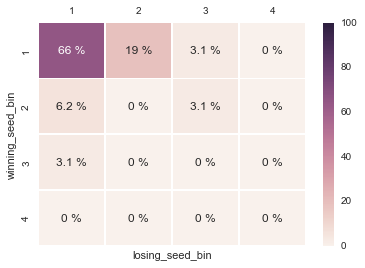

In [37]:
break_num = 6
for i in reversed(range(1, 8)):
    
    if i == break_num:
        break
    
    print('Round ', str(i))
    pl.clf()  # this is not working !! 
    
    fig = sns.set()
    tmp = seed_vs_seed(seed_data, i)
    
    # normalise:
    norm_factor = tmp.sum().sum()
    tmp = round(tmp / norm_factor * 100, 1)
    
    ax = sns.heatmap(tmp, linewidths=.5, annot=True, vmin=0, vmax=100)
    ax.xaxis.tick_top()
    for t in ax.texts: 
        t.set_text(t.get_text() + " %")
    pl.show()  

### Want to show change in proportions over the years.

In [38]:
len(data.year.unique())

32

In [39]:
seed_year = data.groupby(['winning_seed_bin', 'losing_seed_bin', 'year_bin',
                          'round_num']).count()['date'].reset_index().fillna(0)

In [40]:
def rem_xy():
    '''Removes superfluous x ticks when multiple subplots  share
    their axis works only in pylab mode but can easily be rewritten
    for api use'''
    nr_ax=len(pl.gcf().get_axes())
    count=0
    for z in reversed(pl.gcf().get_axes()):
        if count == nr_ax-1: break
        
        pl.setp(z.get_yticklabels(),visible=False)
        pl.setp(z.get_xticklabels(),visible=False)
        
        z.set_ylabel('')
        z.set_xlabel('')
        count+=1

In [41]:
# some names in the round names dictionary a bit too long so let's rename a few:
round_dict['Ntl Champ'] = round_dict.pop('National Championship')
round_dict['Ntl Semis'] = round_dict.pop('National Semifinals')

In [42]:
ivd = {v: k for k, v in round_dict.items()}

In [43]:
ivd

{1: 'Opening Round',
 2: 'Round of 64',
 3: 'Round of 32',
 4: 'Sweet Sixteen',
 5: 'Elite Eight',
 6: 'Ntl Semis',
 7: 'Ntl Champ'}

In [44]:
def add_labels(y_subplots=[6, 13, 20, 27, 34, 41],
              x_subplots=range(35, 42)):
    
    nr_ax=len(pl.gcf().get_axes())
    count=0
    for k, z in enumerate(pl.gcf().get_axes()):
        
        if k in y_subplots:
            z.set_ylabel(ivd[(k + 1 + 7) // 7],  fontsize=14)
            z.yaxis.set_label_position("right")
        
        if k in x_subplots:
            key_val = k % 7 + 1
            z.set_xlabel(bin_dict[key_val], fontsize=16)

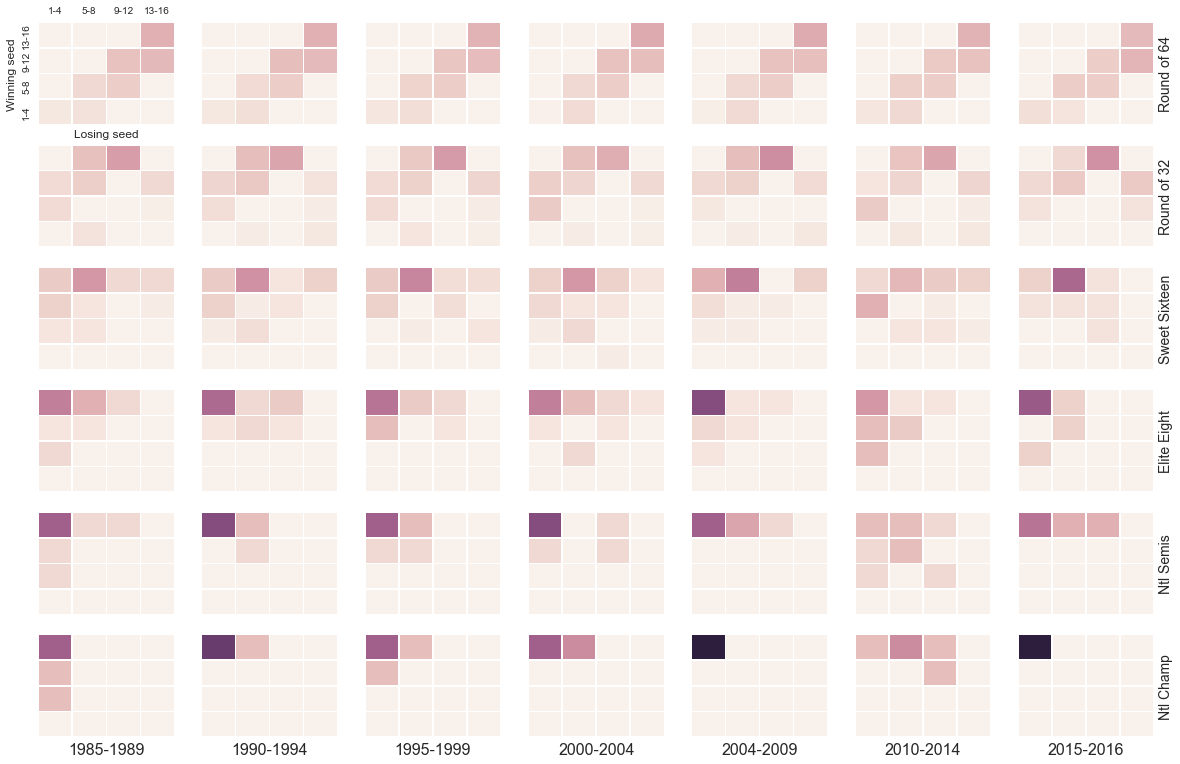

In [47]:
p = 1
sns.set()
pl.tight_layout
pl.figure(figsize=(20, 15))

for round_num in range(2, 8):
    
    for year in range(1, 8):

        tmp = seed_year[seed_year.year_bin == year]
        tmp = tmp[tmp.round_num==round_num]  # set round number
        tmp = tmp[['winning_seed_bin', 'losing_seed_bin', 
                   'date']].pivot('winning_seed_bin', 'losing_seed_bin', 'date')

        # normalise:
        norm_factor = tmp.sum().sum()
        tmp = round(tmp / norm_factor * 100, 1)

        ax_sp = pl.subplot(7, 7, p)
        ax = sns.heatmap(tmp, linewidths=.5, vmin=0, vmax=100, ax=ax_sp, cbar=False,)
        ax.set_xticklabels(['1-4', '5-8', '9-12', '13-16'])
        ax.set_yticklabels(['1-4', '5-8', '9-12', '13-16'])
        ax.xaxis.tick_top()
        
        ax.set_ylabel('Winning seed', fontsize=12)
        ax.set_xlabel('Losing seed',  fontsize=12)
        p += 1

    rem_xy()
    add_labels()
pl.savefig('NCCA.png')
pl.show()  

**STILL TODO:**
- Need to add a legend here with an explanation of how I binned the seeds (explains the black boxes). 